In [60]:
import os

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split


from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS

from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy

In [61]:
np.random.seed(0)

In [62]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))

chainsaw
fire
fireworks
gunshot


In [63]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
new_dataset_dir = "src/classification/datasets/new_dataset/melvecs/"
model_dir = "data/models/xgboost"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [64]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=0.0)

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

idx = 0

# XGBOOST PARAMETERS
n_estimators = 259
max_depth = 9
learning_rate = 0.2446
subsample = 0.5064
colsample_bytree = 0.8427

In [65]:
# TRANSFORMATION ON FEATURE VECTOR

def add_noise(feature_vector, snr_db=20):
    """Adds white noise to a feature vector based on the given SNR (Signal-to-Noise Ratio)."""
    power_signal = np.mean(feature_vector ** 2)
    power_noise = power_signal / (10 ** (snr_db / 10))
    noise = np.random.normal(0, np.sqrt(power_noise), feature_vector.shape)
    return feature_vector + noise

def shifting(feature_vector, shift_max=20):
    """Shifts mel spectrogram feature vectors along the time axis by a random shift between 0 and shift_max."""
    shift = np.random.randint(0, shift_max)
    return np.roll(feature_vector, shift, axis=0)  # Rolling along the first axis

In [66]:

import numpy as np

train_pct = 0.7
data_aug_factor = 1
featveclen = len(myds["fire", 0, "", ""])  # Same for all classes
classnames = ["chainsaw", "fire", "fireworks", "gunshot"]  # Or wherever you store class names
nclass = len(classnames)

# Determine number of samples per class
naudio_per_class = {"chainsaw" : 76, "fire" : 76, "fireworks" : 76, "gunshot" : 40}


# Allocate feature matrix
total_samples_basic = sum(naudio_per_class[c] for c in classnames)
X_basic = np.zeros((total_samples_basic, featveclen))
y_basic = np.zeros((total_samples_basic), dtype=object)
total_samples_basic
# Fill feature matrix
idx = 0
for class_idx, classname in enumerate(classnames):
    for i in range(naudio_per_class[classname]):
        featvec = myds[classname, i, "", ""]
        X_basic[idx, :] = featvec
        y_basic[idx] = classname
        idx += 1

# Save features and labels
np.save(fm_dir + "X_basic.npy", X_basic)
np.save(fm_dir + "y_basic.npy", y_basic)

print(f"Shape of the basic feature matrix : {X_basic.shape}")
print(f"Number of labels : {y_basic.shape}")


Shape of the basic feature matrix : (268, 400)
Number of labels : (268,)


We can now create a new augmented dataset and observe if the classification results improve. 

In [67]:

### AUGMENTED DATASET
list_augmentation = ["original", "noise", "shifting"]
myds.mod_data_aug(list_augmentation)
print("Number of transformations : ", myds.data_aug_factor)


# Calcul total des échantillons
total_aug_samples = sum(naudio_per_class[c] for c in classnames) * len(list_augmentation)
X_basic_aug = np.zeros((total_aug_samples, featveclen))
y_basic_aug = np.zeros((total_aug_samples), dtype=object)

# Remplissage des features
idx = 0
for aug in list_augmentation:
    for classname in classnames:
        for i in range(naudio_per_class[classname]):
            featvec = myds[classname, i, aug, ""]
            X_basic_aug[idx, :] = featvec
            y_basic_aug[idx] = classname
            idx += 1

# Sauvegarde
np.save(fm_dir + "X_basic_aug.npy", X_basic_aug)
np.save(fm_dir + "y_basic_aug.npy", y_basic_aug)

print(f"Shape of the feature matrix : {X_basic_aug.shape}")
print(f"Number of labels : {y_basic_aug.shape}")
print(f"------------------------------------------------------------")
print(f"Transformations: {list_augmentation}. Labels aligned dynamically with class sizes.")


Number of transformations :  3
Shape of the feature matrix : (804, 400)
Number of labels : (804,)
------------------------------------------------------------
Transformations: ['original', 'noise', 'shifting']. Labels aligned dynamically with class sizes.


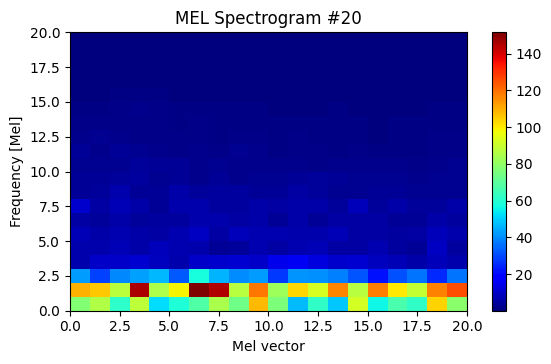

In [68]:
#plot specgram(myds["chainsaw1", 0, "original", ""])
from classification.utils.plots import plot_specgram_textlabel
X_basic_aug = np.load(os.path.join(fm_dir, "X_basic_aug.npy"))
melvec = X_basic_aug[132]
plot_specgram_textlabel(
    melvec.reshape((20, 20)),
    ax=plt.gca(),
    is_mel=True,
    title=f"MEL Spectrogram #{20}",
    xlabel="Mel vector",
    textlabel="",
)


FINAL MODEL SAVE

In [ ]:

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

TEST_SET = False

# Load datasets
X_basic_aug = np.load(os.path.join(fm_dir, "X_basic_aug.npy"))
y_basic_aug = np.load(os.path.join(fm_dir, "y_basic_aug.npy"), allow_pickle=True)

X_basic = np.load(os.path.join(fm_dir, "X_basic.npy"))
y_basic = np.load(os.path.join(fm_dir, "y_basic.npy"), allow_pickle=True)

# Encode labels
label_encoder = LabelEncoder()
y_basic = label_encoder.fit_transform(y_basic)
y_basic_aug = label_encoder.transform(y_basic_aug)


# Split the dataset into training and testing sets
if TEST_SET:
    X_train, X_test, y_train, y_test = train_test_split(X_basic, y_basic, test_size=0.3, random_state=42)
    X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(X_basic_aug, y_basic_aug, test_size=0.3, random_state=42)
else:
    X_train = X_basic
    y_train = y_basic
    X_train_aug = X_basic_aug
    y_train_aug = y_basic_aug

# =========================
# SCENARIO A: WITH PCA (no aug)
# =========================
pca = PCA(n_components=0.98)
X_train_pca = pca.fit_transform(X_train)
if TEST_SET:
    X_test_pca = pca.transform(X_test)

pca_filename = os.path.join(model_dir, "pca_noaug_nonorm.pickle")
with open(pca_filename, "wb") as f:
    pickle.dump(pca, f)

xgb_pca = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                        subsample=0.8, colsample_bytree=0.8, eval_metric='mlogloss', random_state=42)
xgb_pca.fit(X_train_pca, y_train)

model_filename = os.path.join(model_dir, "xgb_pca_noaug_nonorm.pickle")
with open(model_filename, "wb") as f:
    pickle.dump(xgb_pca, f)

# =========================
# SCENARIO B: WITHOUT PCA (no aug)
# =========================
xgb_no_pca = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                           subsample=0.8, colsample_bytree=0.8, eval_metric='mlogloss', random_state=42)
xgb_no_pca.fit(X_train, y_train)

model_filename = os.path.join(model_dir, "xgb_nopca_noaug_nonorm.pickle")
with open(model_filename, "wb") as f:
    pickle.dump(xgb_no_pca, f)

# =========================
# SCENARIO C: WITH PCA (aug)
# =========================
pca = PCA(n_components=0.98)
X_train_aug_pca = pca.fit_transform(X_train_aug)
if TEST_SET:
    X_test_aug_pca = pca.transform(X_test_aug)

pca_filename = os.path.join(model_dir, "pca_aug_nonorm.pickle")
with open(pca_filename, "wb") as f:
    pickle.dump(pca, f)

xgb_model_pca = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                              subsample=subsample, colsample_bytree=colsample_bytree,
                              eval_metric='mlogloss', random_state=42)
xgb_model_pca.fit(X_train_aug_pca, y_train_aug)

model_filename = os.path.join(model_dir, "xgb_pca_aug_nonorm.pickle")
with open(model_filename, "wb") as f:
    pickle.dump(xgb_model_pca, f)

# =========================
# SCENARIO D: WITHOUT PCA (aug)
# =========================
xgb_model_no_pca = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                                 subsample=subsample, colsample_bytree=colsample_bytree,
                                 eval_metric='mlogloss', random_state=42)
xgb_model_no_pca.fit(X_train_aug, y_train_aug)

model_filename = os.path.join(model_dir, "xgb_nopca_aug_nonorm.pickle")
with open(model_filename, "wb") as f:
    pickle.dump(xgb_model_no_pca, f)

# =========================
# SCENARIO E: NO DATA TRANSFORMATION (no aug)
# =========================
xgb_model_no_transform = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                                       subsample=subsample, colsample_bytree=colsample_bytree,
                                       eval_metric='mlogloss', random_state=42)
xgb_model_no_transform.fit(X_train, y_train)

model_filename = os.path.join(model_dir, "xgb_nopca_noaug_nonorm.pickle")
with open(model_filename, "wb") as f:
    pickle.dump(xgb_model_no_transform, f)

# =========================
# SCENARIO F: NORMALIZATION + PCA (no aug)
# =========================
X_train_norm = np.array([x/np.linalg.norm(x) if np.linalg.norm(x) != 0 else x for x in X_train])
if TEST_SET:
    X_test_norm = np.array([x/np.linalg.norm(x) if np.linalg.norm(x) != 0 else x for x in X_test])

pca = PCA(n_components=0.98)
X_train_norm_pca = pca.fit_transform(X_train_norm)
if TEST_SET:
    X_test_norm_pca = pca.transform(X_test_norm)

pca_filename = os.path.join(model_dir, "pca_noaug_norm.pickle")
with open(pca_filename, "wb") as f:
    pickle.dump(pca, f)

xgb_model_norm_pca = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                                   subsample=subsample, colsample_bytree=colsample_bytree,
                                   eval_metric='mlogloss', random_state=42)
xgb_model_norm_pca.fit(X_train_norm_pca, y_train)

model_filename = os.path.join(model_dir, "xgb_pca_noaug_norm.pickle")
with open(model_filename, "wb") as f:
    pickle.dump(xgb_model_norm_pca, f)

# =========================
# SCENARIO G: NORMALIZATION + AUG + PCA
# =========================
X_train_aug_norm = np.array([x/np.linalg.norm(x) if np.linalg.norm(x) != 0 else x for x in X_train_aug])
if TEST_SET:
    X_test_aug_norm = np.array([x/np.linalg.norm(x) if np.linalg.norm(x) != 0 else x for x in X_test_aug])

pca = PCA(n_components=0.98)
X_train_aug_norm_pca = pca.fit_transform(X_train_aug_norm)
if TEST_SET:
    X_test_aug_norm_pca = pca.transform(X_test_aug_norm)

pca_filename = os.path.join(model_dir, "pca_aug_norm.pickle")
with open(pca_filename, "wb") as f:
    pickle.dump(pca, f)

xgb_model_norm_aug_pca = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                                       subsample=subsample, colsample_bytree=colsample_bytree,
                                       eval_metric='mlogloss', random_state=42)
xgb_model_norm_aug_pca.fit(X_train_aug_norm_pca, y_train_aug)

model_filename = os.path.join(model_dir, "xgb_pca_aug_norm.pickle")
with open(model_filename, "wb") as f:
    pickle.dump(xgb_model_norm_aug_pca, f)

# =========================
# EVALUATION FUNCTION
# =========================
def evaluate_model(model, X_test, y_test, description):
    predict = model.predict(X_test)

    classes = np.unique(y_test)
    precision_per_class = precision_score(y_test, predict, average=None, labels=classes)
    recall_per_class = recall_score(y_test, predict, average=None, labels=classes)
    test_accuracy_per_class = []
    conf_matrix = confusion_matrix(y_test, predict, labels=classes)

    for i, cls in enumerate(classes):
        acc = conf_matrix[i, i] / conf_matrix[i, :].sum()
        test_accuracy_per_class.append(acc)

    cv_scores = cross_val_score(model, X_test, y_test, cv=5, scoring='accuracy')
    mean_cv_accuracy = np.mean(cv_scores)

    print(f"\n=== {description} ===")
    print(f"Test Accuracy (Overall): {np.mean(predict == y_test):.4f}")
    print(f"Mean CV Accuracy: {mean_cv_accuracy:.4f}")

    print("\nPer-Class Metrics:")
    for i, cls in enumerate(classes):
        print(f"Class {cls}: Precision={precision_per_class[i]:.4f}, Recall={recall_per_class[i]:.4f}, Accuracy={test_accuracy_per_class[i]:.4f}")

# =========================
# EVALUATE ALL MODELS
# =========================
if TEST_SET:
    evaluate_model(xgb_pca, X_test_pca, y_test, "Scenario A: PCA NOAUG NONORM")
    evaluate_model(xgb_no_pca, X_test, y_test, "Scenario B: NOPCA NOAUG NONORM")
    evaluate_model(xgb_model_pca, X_test_aug_pca, y_test_aug, "Scenario C: PCA AUG NONORM")
    evaluate_model(xgb_model_no_pca, X_test, y_test, "Scenario D: NOPCA AUG NONORM")
    evaluate_model(xgb_model_no_transform, X_test, y_test, "Scenario E: NOPCA NOAUG NONORM")
    evaluate_model(xgb_model_norm_pca, X_test_norm_pca, y_test, "Scenario F: PCA NOAUG NORM")
    evaluate_model(xgb_model_norm_aug_pca, X_test_aug_norm_pca, y_test_aug, "Scenario G: PCA AUG NORM")

HYPERPARAMETER TUNING

In [70]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from bayes_opt import BayesianOptimization

# Your custom accuracy function
from classification.utils.utils import accuracy

# --- CONFIG FLAGS ---
NORMALIZATION = False
TRANSFORMATION = True

# --- STEP 1: Load/Select Data ---
if TRANSFORMATION:
    try:
        X = X_basic_aug   # Make sure X_basic_aug is defined in your environment
        y = y_basic_aug   # Make sure y_basic_aug is defined in your environment
    except NameError:
        raise ValueError("X_aug and y_aug must be defined before running this script.")
else:
    try:
        X = X_basic       # Make sure X_basic is defined in your environment
        y = y_basic       # Make sure y_basic is defined in your environment
    except NameError:
        raise ValueError("X and y must be defined before running this script.")

# Optional normalization
if NORMALIZATION:
    X = np.array([
        x / np.linalg.norm(x) if np.linalg.norm(x) != 0 else x
        for x in X
    ])

# --- STEP 2: Define the Objective Function for Bayesian Optimization ---
def xgb_cv(
    n_estimators,
    max_depth,
    learning_rate,
    subsample,
    colsample_bytree
):
    """
    This function trains an XGBClassifier with given hyperparameters
    and returns the mean CV accuracy as the objective to maximize.
    """
    # Convert some parameters to int, as required by XGBoost
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)

    model = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, colsample_bytree=colsample_bytree,
        eval_metric='mlogloss',
        # remove use_label_encoder (deprecated)
        random_state=42
    )
    
    # 5-fold cross-validation on the *entire dataset* X, y
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    
    # Return the mean of cross-validation accuracy
    return cv_scores.mean()

# --- STEP 3: Set Up the Bayesian Optimizer ---
# Hyperparameter search space
pbounds = {
    'n_estimators': (50, 400),      # e.g. from 50 to 300
    'max_depth': (2, 15),           # integer between 2 and 12
    'learning_rate': (0.01, 0.3),   # from 0.01 to 0.3
    'subsample': (0.5, 1),        # from 0.5 to 1.0
    'colsample_bytree': (0.5, 1)  # from 0.5 to 1.0
}

optimizer = BayesianOptimization(
    f=xgb_cv,        # The function we want to maximize
    pbounds=pbounds, # The search space
    random_state=42  # Ensures reproducibility
)

# --- STEP 4: Run the Bayesian Optimization Loop ---
# We'll do a few initial random explorations (init_points) 
# and then a certain number of optimization steps (n_iter).
init_points = 3
n_iter = 20

print("Starting Bayesian Optimization...")
best_score_so_far = -1.0
early_stop_threshold = 0.90  # Stop if we exceed 90% cross-val accuracy

optimizer.maximize(init_points=init_points, n_iter=n_iter)

for i, res in enumerate(optimizer.res):
    score = res['target']
    print(f"Iteration {i+1}, CV Accuracy: {score:.4f}, Parameters: {res['params']}")
    
    if score > best_score_so_far:
        best_score_so_far = score
    
    # Early stopping if we found a "good" configuration
    if best_score_so_far > early_stop_threshold:
        print(f"\nEarly stopping: Found cross-validation accuracy above {early_stop_threshold}\n")
        break

# --- STEP 5: Get the Best Found Hyperparameters ---
best_params = optimizer.max['params']
best_n_estimators = int(best_params['n_estimators'])
best_max_depth = int(best_params['max_depth'])
best_learning_rate = best_params['learning_rate']
best_subsample = best_params['subsample']
best_colsample_bytree = best_params['colsample_bytree']

print("\n=== BEST HYPERPARAMETERS FOUND ===")
print(f"n_estimators = {best_n_estimators}")
print(f"max_depth = {best_max_depth}")
print(f"learning_rate = {best_learning_rate:.4f}")
print(f"subsample = {best_subsample:.4f}")
print(f"colsample_bytree = {best_colsample_bytree:.4f}")
print(f"CV Accuracy = {optimizer.max['target']:.4f}")

# --- STEP 6: Train/Validate Model Once More on a Train/Test Split ---
# Final check on a separate holdout set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=999
)

final_model = XGBClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    learning_rate=best_learning_rate,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    eval_metric='mlogloss',
    random_state=999
)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)
test_acc = accuracy(y_pred, y_test)

print("\n=== FINAL EVALUATION ON HOLDOUT TEST SET ===")
print(f"Test Accuracy: {test_acc:.4f}")


Starting Bayesian Optimization...
|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.919     | 0.6873    | 0.2857    | 11.52     | 259.5     | 0.578     |
| 2         | 0.9103    | 0.578     | 0.02684   | 13.26     | 260.4     | 0.854     |
| 3         | 0.9203    | 0.5103    | 0.2913    | 12.82     | 124.3     | 0.5909    |
| 4         | 0.919     | 0.7083    | 0.2484    | 13.05     | 124.2     | 0.8287    |
| 5         | 0.9165    | 0.5358    | 0.1226    | 11.52     | 124.8     | 0.8773    |
| 6         | 0.9103    | 0.584     | 0.02728   | 10.21     | 258.8     | 0.5973    |
| 7         | 0.9277    | 0.7569    | 0.2999    | 12.08     | 123.7     | 0.571     |
| 8         | 0.9227    | 0.6008    | 0.2221    | 12.36     | 122.9     | 0.573     |
| 9         | 0.9065    | 0.7425    | 0.06019   | 11.64     | 123.5     | 0.9047    |
| 10        | 0.9115

MEAN ACCURACY ON 100 ITERATIONS

In [71]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from classification.utils.utils import accuracy


NORMALIZATION = True
TRANSFORMATION = True

# Ensure dataset (X_aug, y_aug) exists
if TRANSFORMATION:
    try:
        X = X_basic_aug
        y = y_basic_aug
    except NameError:
        raise ValueError("X_aug and y_aug must be defined before running this script.")
else:
    try:
        X = X_basic
        y = y_basic
    except NameError:
        raise ValueError("X and y must be defined before running this script.")

# Normalize if needed
if NORMALIZATION:
    X = np.array([x / np.linalg.norm(x) if np.linalg.norm(x) != 0 else x for x in X])

# Number of iterations
num_iterations = 3

# Lists to store scores
accuracy_scores = []
cv_accuracy_scores = []

for i in range(num_iterations):
    print(f"\nIteration {i + 1}/{num_iterations}")
    
    # Split the dataset into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=i
    )

    # Train the XGBoost model
    model = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mlogloss',
        random_state=i
    )
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Compute overall accuracy
    test_accuracy = accuracy(y_pred, y_test)
    accuracy_scores.append(test_accuracy)

    # Perform cross-validation on the training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    mean_cv_accuracy = np.mean(cv_scores)
    cv_accuracy_scores.append(mean_cv_accuracy)

    print(f"Test Accuracy: {test_accuracy:.4f} | Mean CV Accuracy: {mean_cv_accuracy:.4f}")

# Compute overall statistics
mean_test_accuracy = np.mean(accuracy_scores)
std_test_accuracy = np.std(accuracy_scores)

mean_cv_accuracy = np.mean(cv_accuracy_scores)
std_cv_accuracy = np.std(cv_accuracy_scores)

# Print final results
print("\n=== FINAL RESULTS AFTER 20 ITERATIONS ===")
print(f"Mean Test Accuracy: {mean_test_accuracy:.4f} ± {std_test_accuracy:.4f}")
print(f"Mean Cross-Validation Accuracy: {mean_cv_accuracy:.4f} ± {std_cv_accuracy:.4f}")



Iteration 1/3
Test Accuracy: 0.9091 | Mean CV Accuracy: 0.8860

Iteration 2/3
Test Accuracy: 0.9174 | Mean CV Accuracy: 0.9004

Iteration 3/3
Test Accuracy: 0.9174 | Mean CV Accuracy: 0.9004

=== FINAL RESULTS AFTER 20 ITERATIONS ===
Mean Test Accuracy: 0.9146 ± 0.0039
Mean Cross-Validation Accuracy: 0.8956 ± 0.0068


In [72]:
# PCA TESTS

# Rewriting the user's friend's approach using the user's own data and structure.

import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from matplotlib.backends.backend_pdf import PdfPages


# Load datasets
X_aug = np.load(os.path.join(fm_dir, "X_basic_aug.npy"))
y_aug = np.load(os.path.join(fm_dir, "y_basic_aug.npy"), allow_pickle=True)

# Label encoding
label_encoder = LabelEncoder()
y_aug_encoded = label_encoder.fit_transform(y_aug)
classnames = label_encoder.classes_

# Normalize data
X_aug_normalized = np.array([x / np.linalg.norm(x) if np.linalg.norm(x) != 0 else x for x in X_aug])

# Split data
X_train_normalized, X_test_normalized, y_train, y_test = train_test_split(
    X_aug_normalized, y_aug_encoded, test_size=0.3, random_state=42)

# Best hyperparameters for XGBoost
best_params = {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.2,
               'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50,
               'subsample': 0.8}

# Define model
best_xgc = XGBClassifier(
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    min_child_weight=best_params['min_child_weight'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    objective="multi:softmax",
    num_class=len(classnames),
    random_state=42
)

# [1] Evaluate without PCA
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies_no_pca = []

for train_idx, val_idx in kf.split(X_train_normalized, y_train):
    best_xgc.fit(X_train_normalized[train_idx], y_train[train_idx])
    y_pred = best_xgc.predict(X_train_normalized[val_idx])
    accuracy = accuracy_score(y_train[val_idx], y_pred)
    accuracies_no_pca.append(accuracy)

mean_accuracy_no_pca = np.mean(accuracies_no_pca)
print(f"Mean Accuracy without PCA: {mean_accuracy_no_pca * 100:.2f}%")

# [2] Evaluate with PCA (1 to 50 components)
pca_components = range(1, min(X_train_normalized.shape[1], 50))
mean_accuracies_with_pca = []

for n_components in pca_components:
    accuracies_with_pca = []
    pca = PCA(n_components=n_components, whiten=True)

    for train_idx, val_idx in kf.split(X_train_normalized, y_train):
        X_train_pca = pca.fit_transform(X_train_normalized[train_idx])
        X_val_pca = pca.transform(X_train_normalized[val_idx])

        best_xgc.fit(X_train_pca, y_train[train_idx])
        y_pred = best_xgc.predict(X_val_pca)
        accuracy = accuracy_score(y_train[val_idx], y_pred)
        accuracies_with_pca.append(accuracy)

    mean_accuracy_with_pca = np.mean(accuracies_with_pca)
    mean_accuracies_with_pca.append(mean_accuracy_with_pca)
    print(f"PCA components: {n_components}, Mean Accuracy: {mean_accuracy_with_pca * 100:.2f}%")

# [3] Plot results
plt.figure(figsize=(10, 6))
plt.plot(pca_components, [acc * 100 for acc in mean_accuracies_with_pca], marker='o', label='With PCA')
plt.axhline(y=mean_accuracy_no_pca * 100, color='r', linestyle='--', label='Without PCA')
plt.xlabel('Number of PCA Components')
plt.xticks(np.arange(0, 50, 5))
plt.ylabel('Mean Accuracy (%)')
plt.title('Comparison of XGBoost with and without PCA')
plt.grid(True)
plt.legend()

# Save to PDF
pdf_filename = os.path.join(model_dir, "GB_with_vs_without_pca.pdf")
with PdfPages(pdf_filename) as pdf:
    pdf.savefig()
    plt.close()

# [4] Final evaluation on test set with 29 PCA components
pca_final = PCA(n_components=29, whiten=True)
X_train_pca_final = pca_final.fit_transform(X_train_normalized)
X_test_pca_final = pca_final.transform(X_test_normalized)

# Save PCA model
filename_pca = os.path.join(model_dir, "pca_29_GB_components.pickle")
pickle.dump(pca_final, open(filename_pca, "wb"))

# Train final model
best_xgc.fit(X_train_pca_final, y_train)

# Save model
filename_model = os.path.join(model_dir, "best_GB_model.pickle")
pickle.dump(best_xgc, open(filename_model, "wb"))

# Accuracy on test set
y_pred_test = best_xgc.predict(X_test_pca_final)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Test set accuracy with best XGBoost model: {accuracy_test * 100:.2f}%")



Mean Accuracy without PCA: 88.62%
PCA components: 1, Mean Accuracy: 49.65%
PCA components: 2, Mean Accuracy: 56.94%
PCA components: 3, Mean Accuracy: 68.15%
PCA components: 4, Mean Accuracy: 71.72%
PCA components: 5, Mean Accuracy: 76.16%
PCA components: 6, Mean Accuracy: 77.95%
PCA components: 7, Mean Accuracy: 79.73%
PCA components: 8, Mean Accuracy: 80.44%
PCA components: 9, Mean Accuracy: 82.03%
PCA components: 10, Mean Accuracy: 83.82%
PCA components: 11, Mean Accuracy: 85.24%
PCA components: 12, Mean Accuracy: 85.06%
PCA components: 13, Mean Accuracy: 86.48%
PCA components: 14, Mean Accuracy: 86.31%
PCA components: 15, Mean Accuracy: 85.60%
PCA components: 16, Mean Accuracy: 86.48%
PCA components: 17, Mean Accuracy: 85.60%
PCA components: 18, Mean Accuracy: 85.95%
PCA components: 19, Mean Accuracy: 85.42%
PCA components: 20, Mean Accuracy: 86.49%
PCA components: 21, Mean Accuracy: 86.49%
PCA components: 22, Mean Accuracy: 87.56%
PCA components: 23, Mean Accuracy: 86.13%
PCA compo